In [1]:
p1 = 0.01
p3 = 3 * p1**2 * (1-p1) + p1**3 # probability of 2 or 3 errors
print('Probability of (one) bit flip: {}'.format(p1))
print('Probability of a the majority of qubit flip: {:.4f}'.format(p3))

Probability of (one) bit flip: 0.01
Probability of a the majority of qubit flip: 0.0003


### Noise Model 

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'ieee', 'grid'])

In [3]:
## Noise Model 1: bit flip error

# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'measure', 'reset', 'u1', 'cx']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


In [4]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(50e3, 10e3, 4) # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(70e3, 10e3, 4)  # Sampled from normal distribution mean 50 microsec

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'measure', 'reset', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


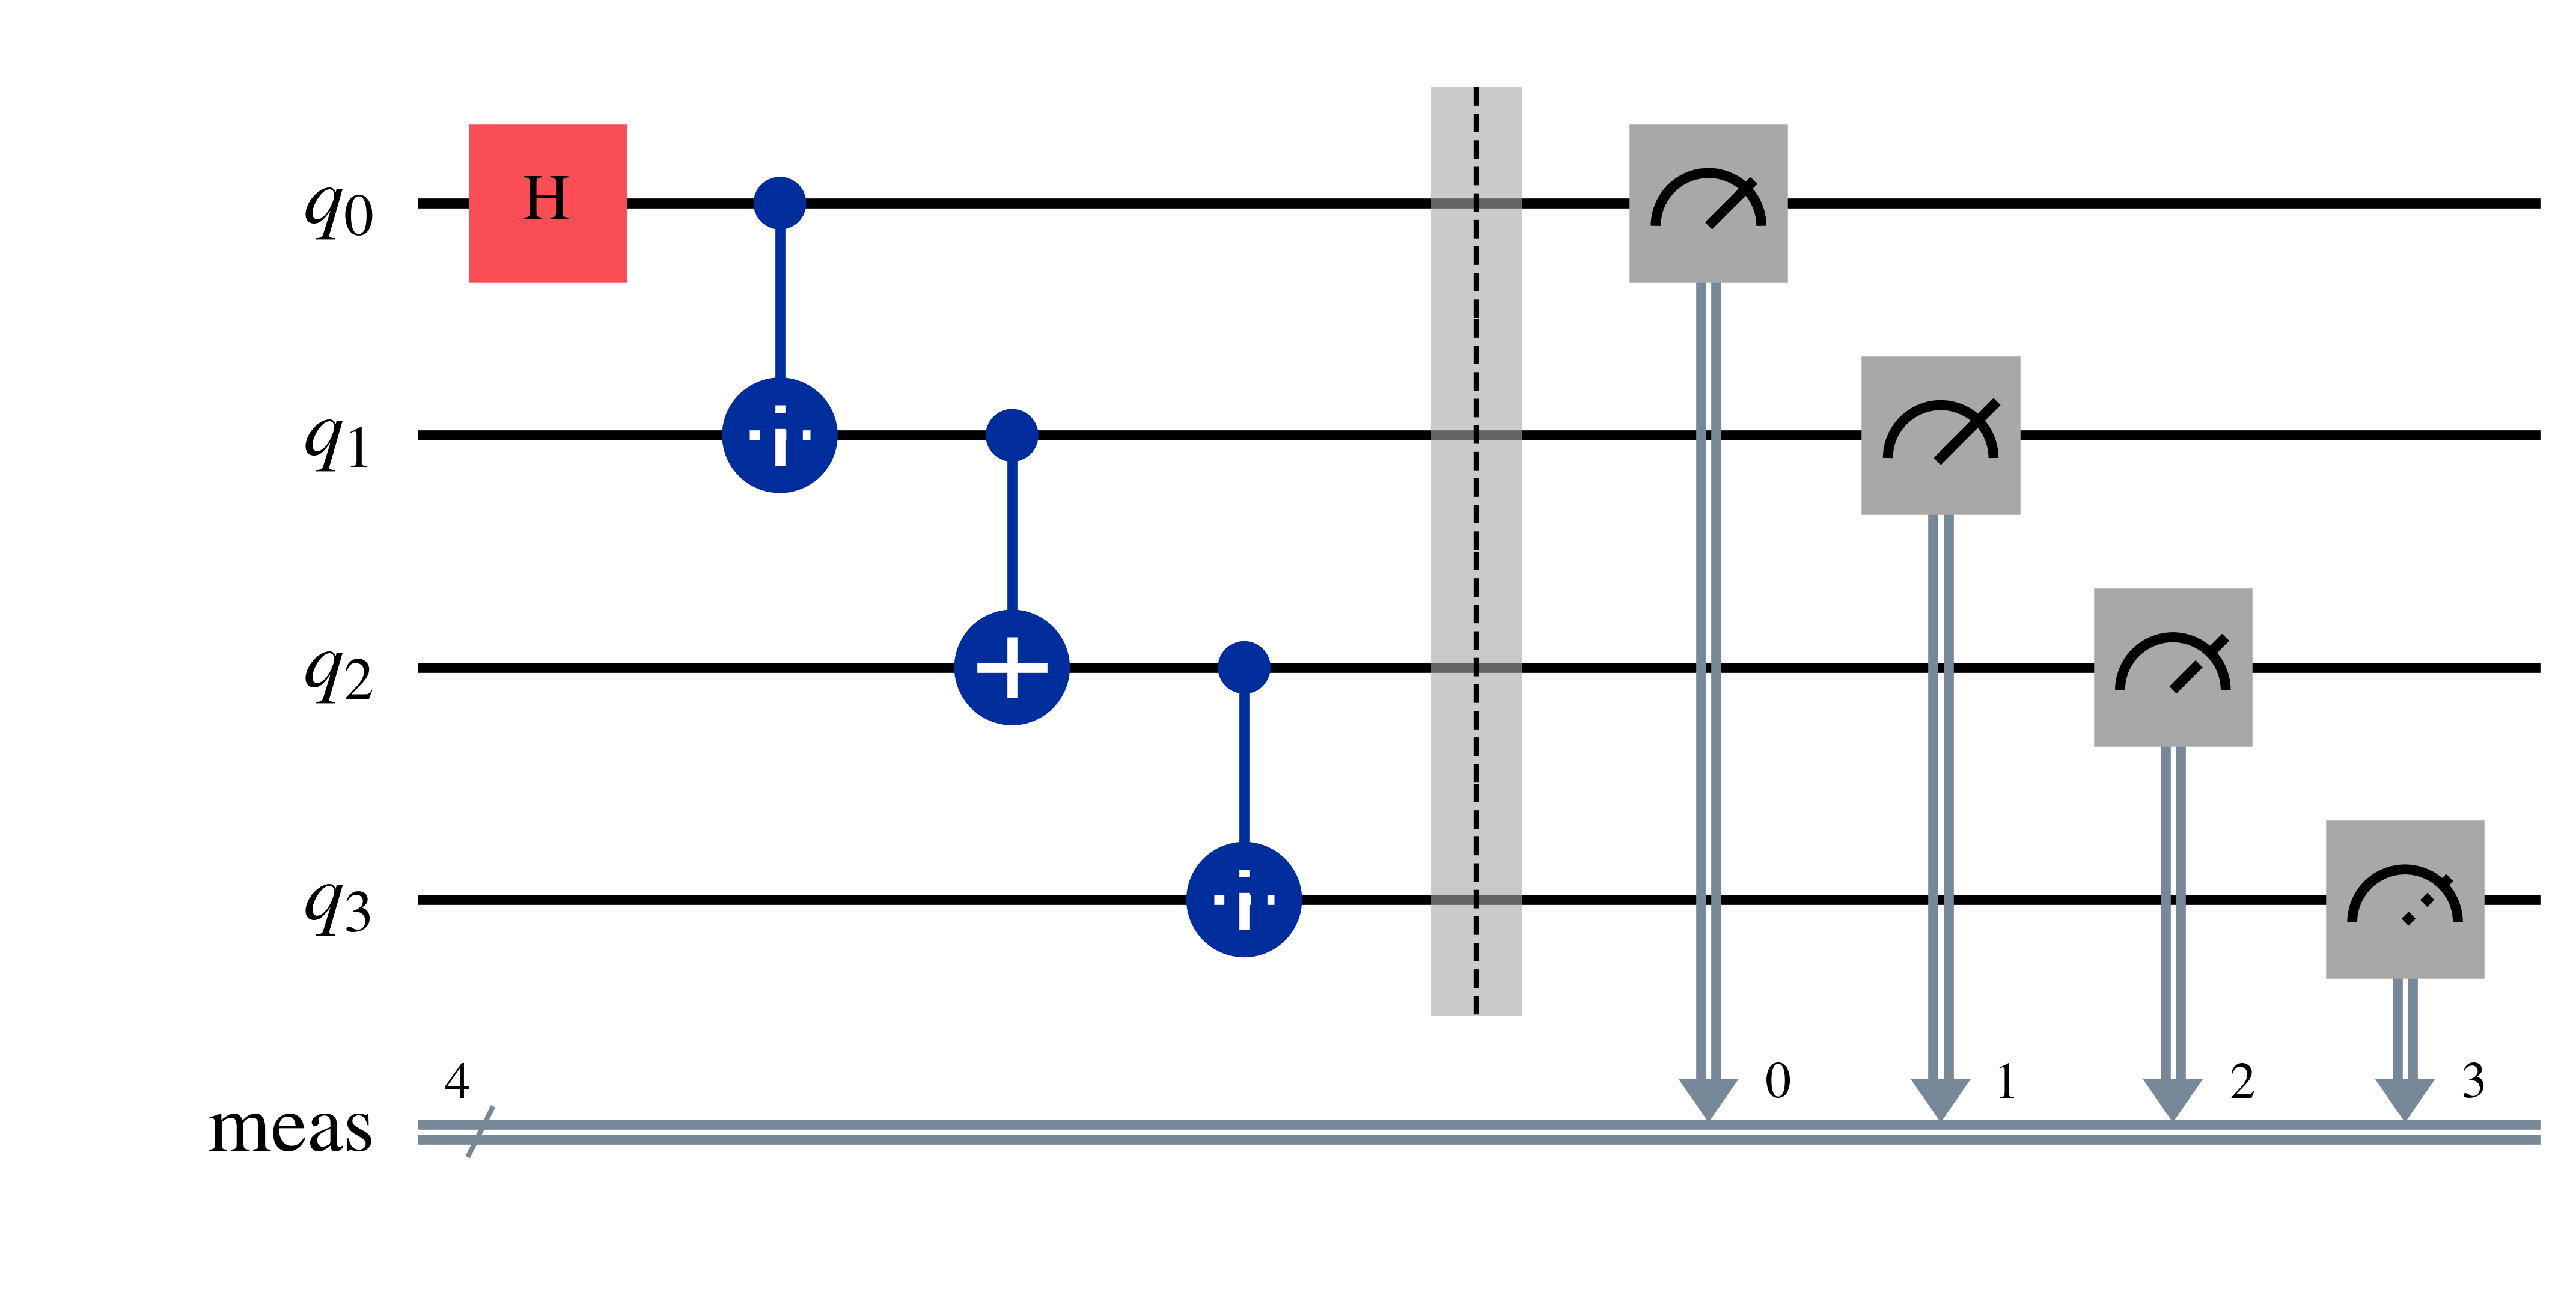

In [5]:
# System Specification
n_qubits = 4
qc0 = QuantumCircuit(n_qubits)

# Test Circuit
qc0.h(0)
for qubit in range(n_qubits - 1):
    qc0.cx(qubit, qubit + 1)
qc0.measure_all()
qc0.draw('mpl')

In [6]:
# Ideal simulator and execution
sim_ideal = AerSimulator()

# noisy simulator bit flip
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
qc0_tnoise = transpile(qc0, sim_noise)

# noisy simulation thermal
sim_thermal = AerSimulator(noise_model=noise_thermal)

# Transpile circuit for noisy basis gates
qc0_tthermal = transpile(qc0, sim_thermal)

In [7]:
# Ideal counts
result_ideal = sim_ideal.run(qc0).result()
counts_ideal = result_ideal.get_counts(0)

# Thermal Noise counts
result_thermal = sim_thermal.run(qc0_tthermal).result()
counts_thermal = result_thermal.get_counts(0)

# Bit Flip counts
result_bit_flip = sim_noise.run(qc0_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

In [8]:
plot_histogram([counts_ideal, counts_bit_flip], legend=['ideal', 'bit-flip noise'], color=['crimson','midnightblue'],
                title="Measurement Outcome for Ideal and Bit-Flip Noise Model", figsize= (20, 10))

In [9]:
# saving the plot
plot_histogram([counts_ideal, counts_bit_flip], legend=['ideal', 'bit-flip noise'], color=['crimson','midnightblue'],
                title="Measurement Outcome for Ideal and Bit-Flip Noise Model", figsize= (20, 10)).savefig('plots/bit_flip_error.pdf')

In [10]:
plot_histogram([counts_ideal, counts_thermal], legend=['ideal', 'thermal noise'], color=['crimson','midnightblue'],
                title="Measurement Outcome for Ideal and Thermal Noise Model", figsize= (20, 10))

In [11]:
# saving the plot
plot_histogram([counts_ideal, counts_thermal], legend=['ideal', 'thermal noise'], color=['crimson','midnightblue'],
                title="Measurement Outcome for Ideal and Thermal Noise Model", figsize= (20, 10)).savefig('plots/thermal_error.pdf')

### Storing qubits

So far, we have considered cases where there is no delay between encoding and decoding. For qubits, this means that there is no significant amount of time that passes between initializing the circuit, and making the final measurements.

However, there are many cases for which there will be a significant delay. As an obvious example, one may wish to encode a quantum state and store it for a long time, like a quantum hard drive. A less obvious but much more important example is performing fault-tolerant quantum computation itself. For this, we need to store quantum states and preserve their integrity during the computation. This must also be done in a way that allows us to manipulate the stored information in any way we need, and which corrects any errors we may introduce when performing the manipulations.

In all cases, we need account for the fact that errors do not only occur when something happens (like a gate or measurement), they also occur when the qubits are idle. Such noise is due to the fact that the qubits interact with each other and their environment. The longer we leave our qubits idle for, the greater the effects of this noise becomes. If we leave them for long enough, we'll encounter a situation like the $p_{meas}=0.5$ case above, where the noise is too strong for errors to be reliably corrected.

The solution is to keep measuring throughout. No qubit is left idle for too long. Instead, information is constantly being extracted from the system to keep track of the errors that have occurred.

For the case of classical information, where we simply wish to store a `0` or `1`, this can be done by just constantly measuring the value of each qubit. By keeping track of when the values change due to noise, we can easily deduce a history of when errors occurred. 

For quantum information, however, it is not so easy. For example, consider the case that we wish to encode the logical state $\left|+\right\rangle$. Our encoding is such that



$$\left|0\right\rangle \rightarrow \left|000\right\rangle, \left|1\right\rangle \rightarrow \left|111\right\rangle.$$



To encode the logical $\left|+\right\rangle$ state we therefore need



$$\left|+\right\rangle =\frac{1}{\sqrt{2}}\left(\left|0\right\rangle+\left|1\right\rangle\right)\rightarrow\frac{1}{\sqrt{2}}\left(\left|000\right\rangle+\left|111\right\rangle\right).$$



With the repetition encoding that we are using, a z measurement (which distinguishes between the $\left|0\right\rangle$ and $\left|1\right\rangle$ states) of the logical qubit is done using a z measurement of each physical qubit. The final result for the logical measurement is decoded from the physical qubit measurement results by simply looking which output is in the majority.

As mentioned earlier, we can keep track of errors on logical qubits that are stored for a long time by constantly performing z measurements of the physical qubits. However, note that this effectively corresponds to constantly performing z measurements of the physical qubits. This is fine if we are simply storing a `0` or `1`, but it has undesired effects if we are storing a superposition. Specifically: the first time we do such a check for errors, we will collapse the superposition.

This is not ideal. If we wanted to do some computation on our logical qubit, or if we wish to perform a basis change before final measurement, we need to preserve the superposition. Destroying it is an error. But this is not an error caused by imperfections in our devices. It is an error that we have introduced as part of our attempts to correct errors. And since we cannot hope to recreate any arbitrary superposition stored in our quantum computer, it is an error that cannot be corrected.

For this reason, we must find another way of keeping track of the errors that occur when our logical qubit is stored for long times. This should give us the information we need to detect and correct errors, and to decode the final measurement result with high probability. However, it should not cause uncorrectable errors to occur during the process by collapsing superpositions that we need to preserve.

The way to do this is with the following circuit element.

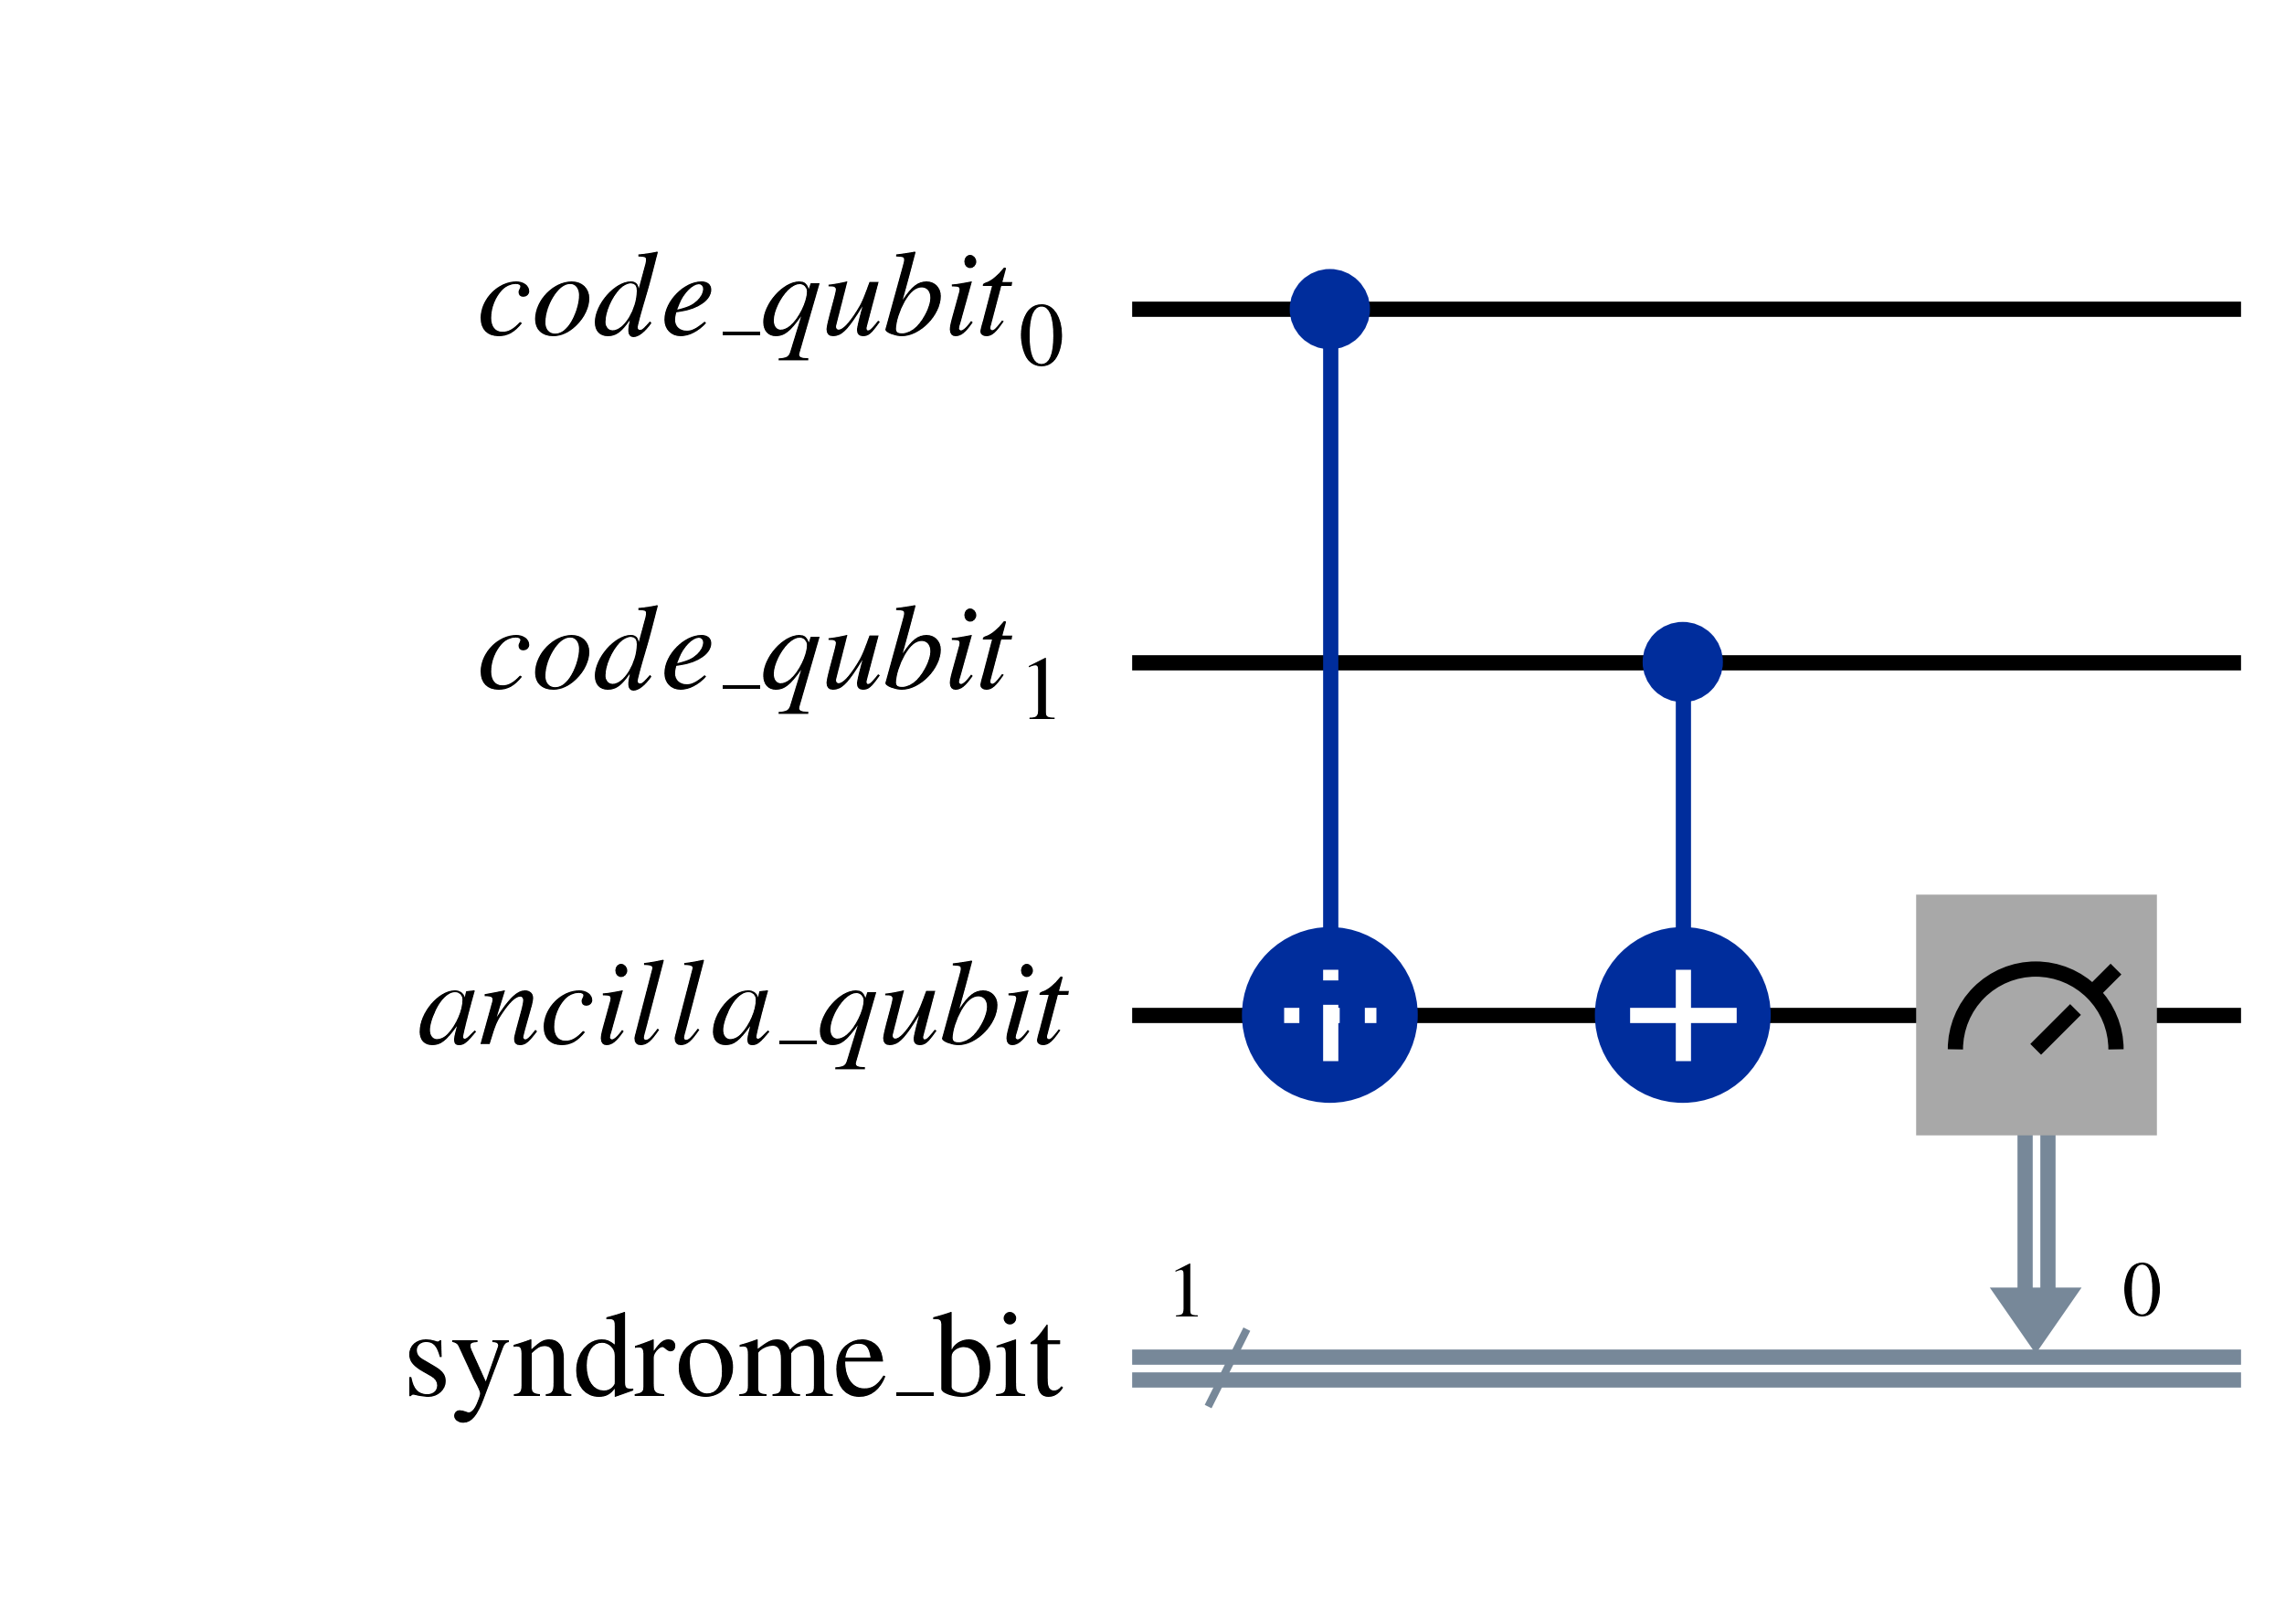

In [12]:
cq = QuantumRegister(2, 'code_qubit')
lq = QuantumRegister(1, 'ancilla_qubit')
sb = ClassicalRegister(1, 'syndrome_bit')
qc = QuantumCircuit(cq, lq, sb)
qc.cx(cq[0], lq[0])
qc.cx(cq[1], lq[0])
qc.measure(lq, sb)
qc.draw('mpl')

## Repetition Code

In [13]:
from circuits import RepetitionCode
from fitters import lookuptable_decoding
from fitters import GraphDecoder

We are free to choose how many physical qubits we want the logical qubit to be encoded in. We can also choose how many times the syndrome measurements will be applied while we store our logical qubit, before the final readout measurement. Let us start with the smallest non-trivial case: three repetitions and one syndrome measurement round. The circuits for the repetition code can then be created automatically from using the `RepetitionCode` object from `topological_codes`.

In [14]:
n = 3
T = 1

code = RepetitionCode(n, T)

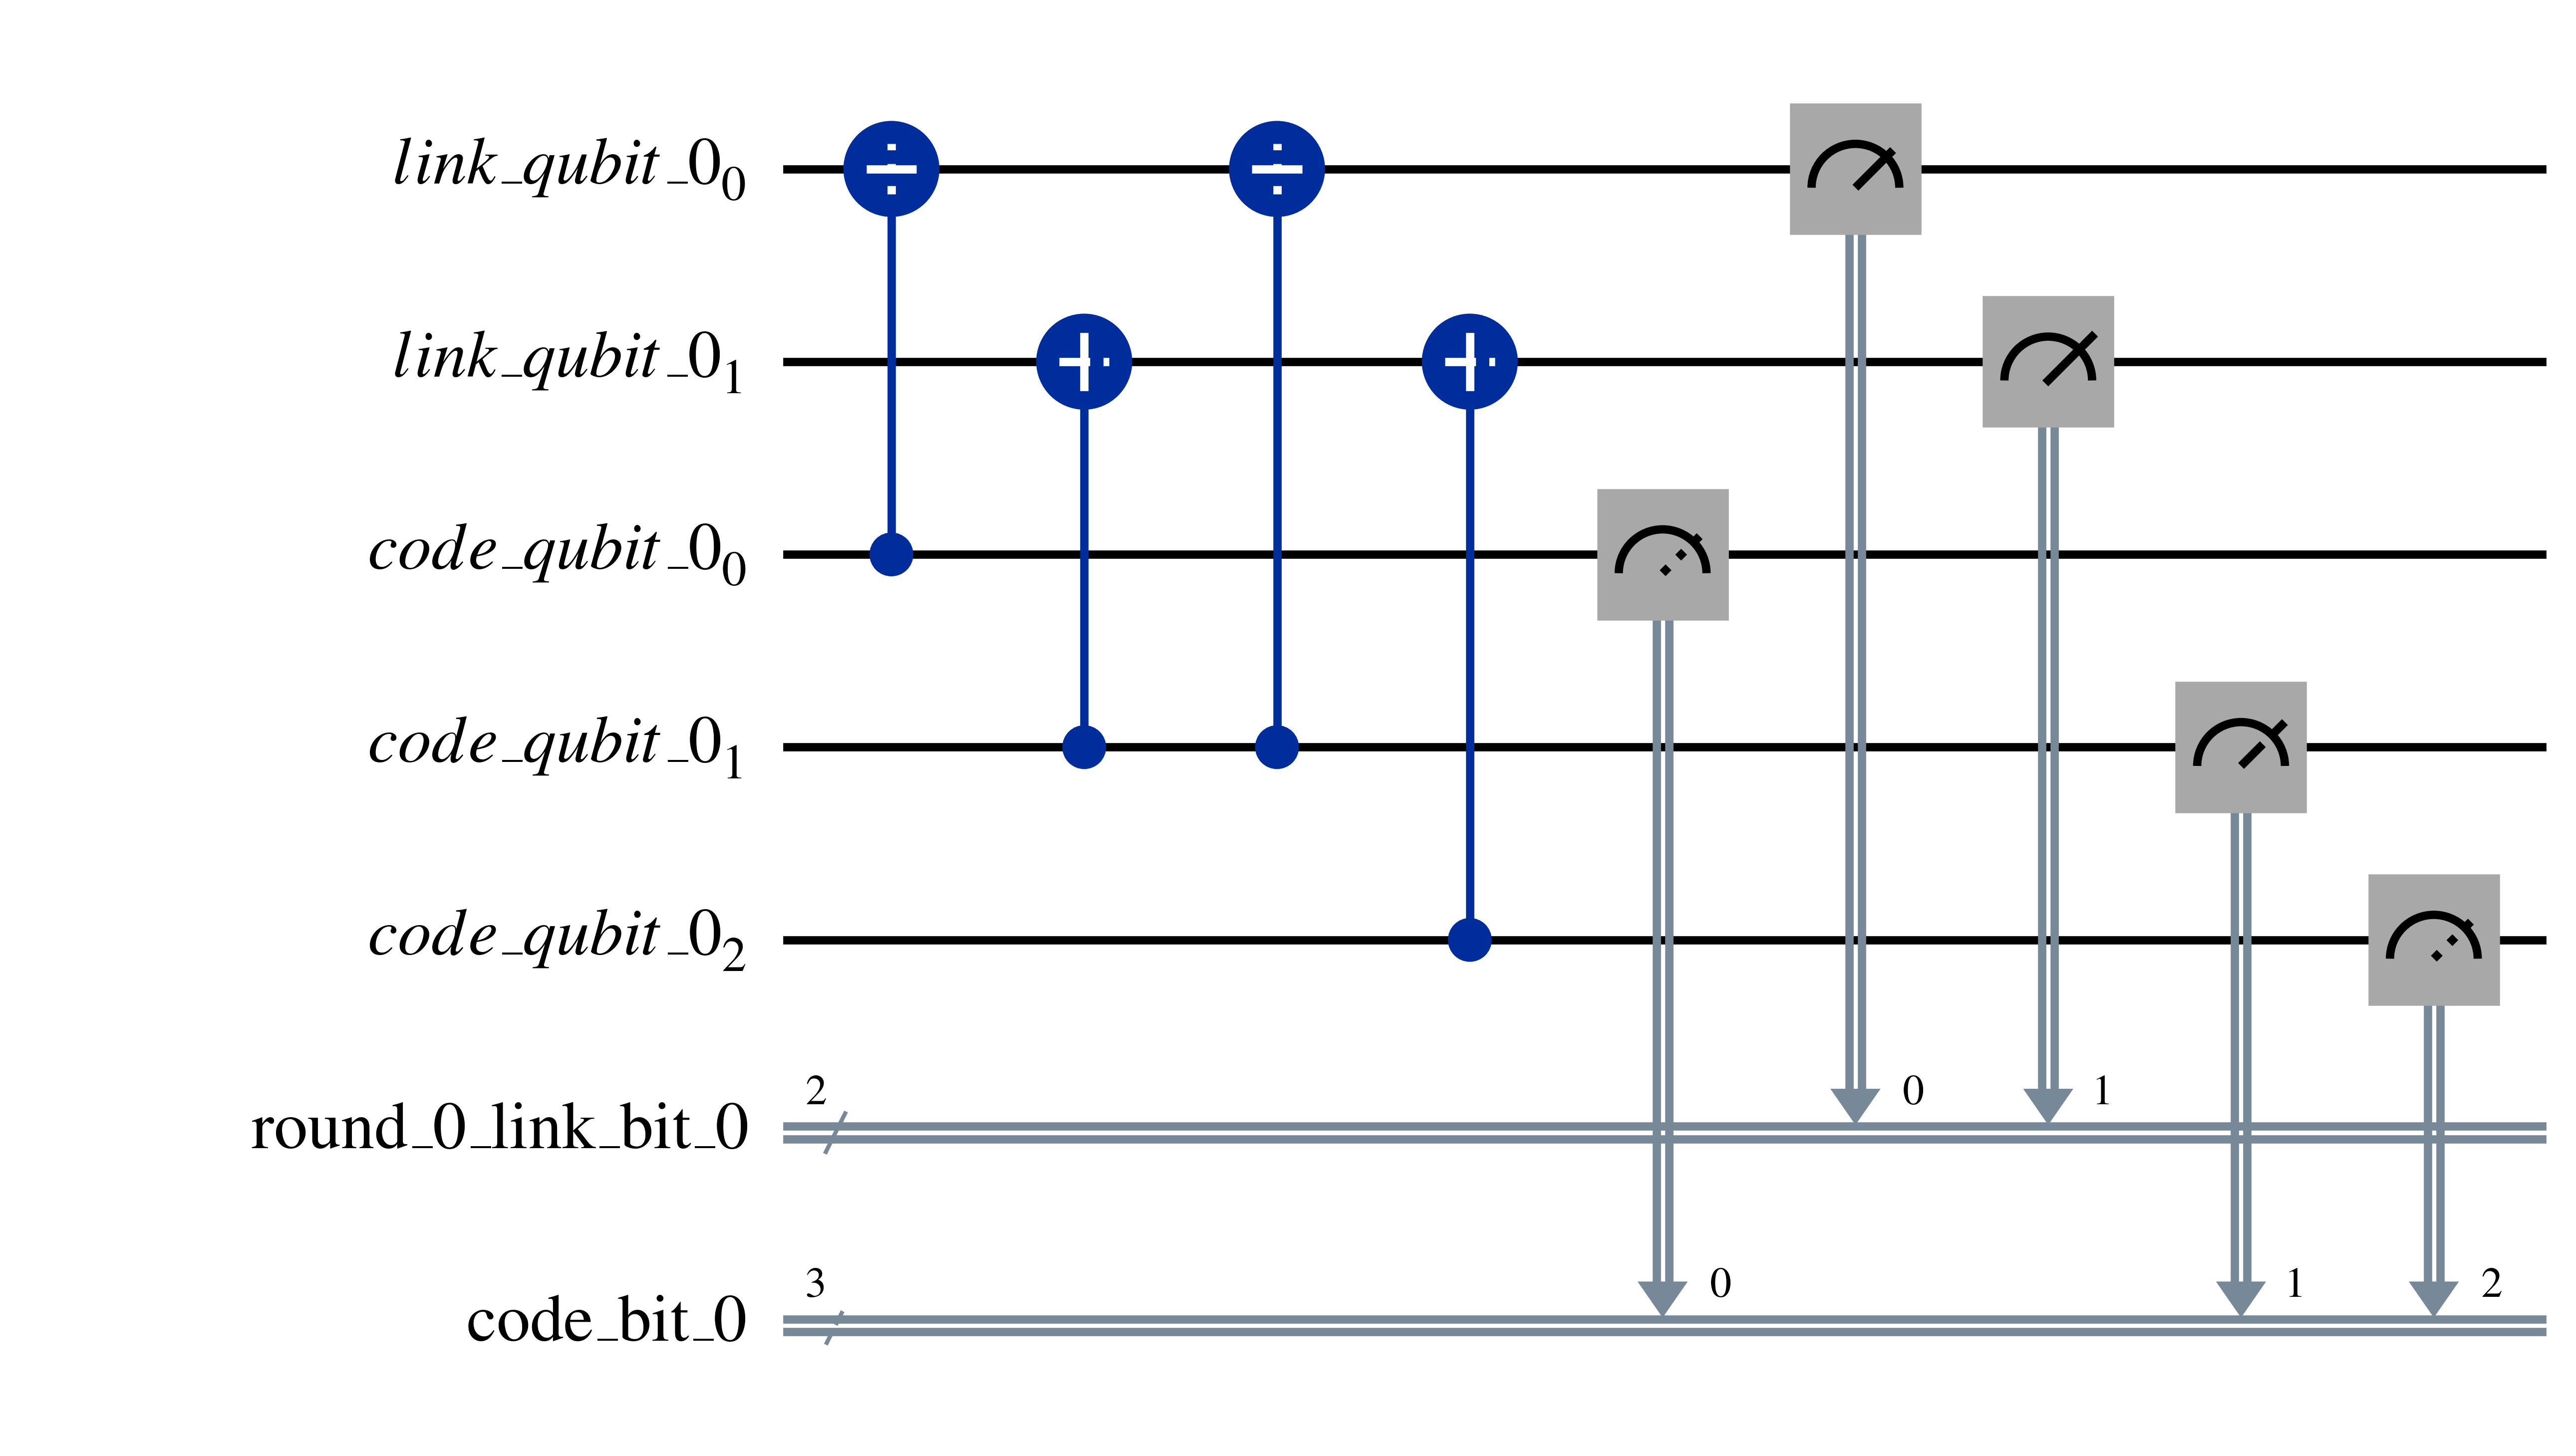

In [15]:
code.circuit['0'].draw('mpl')

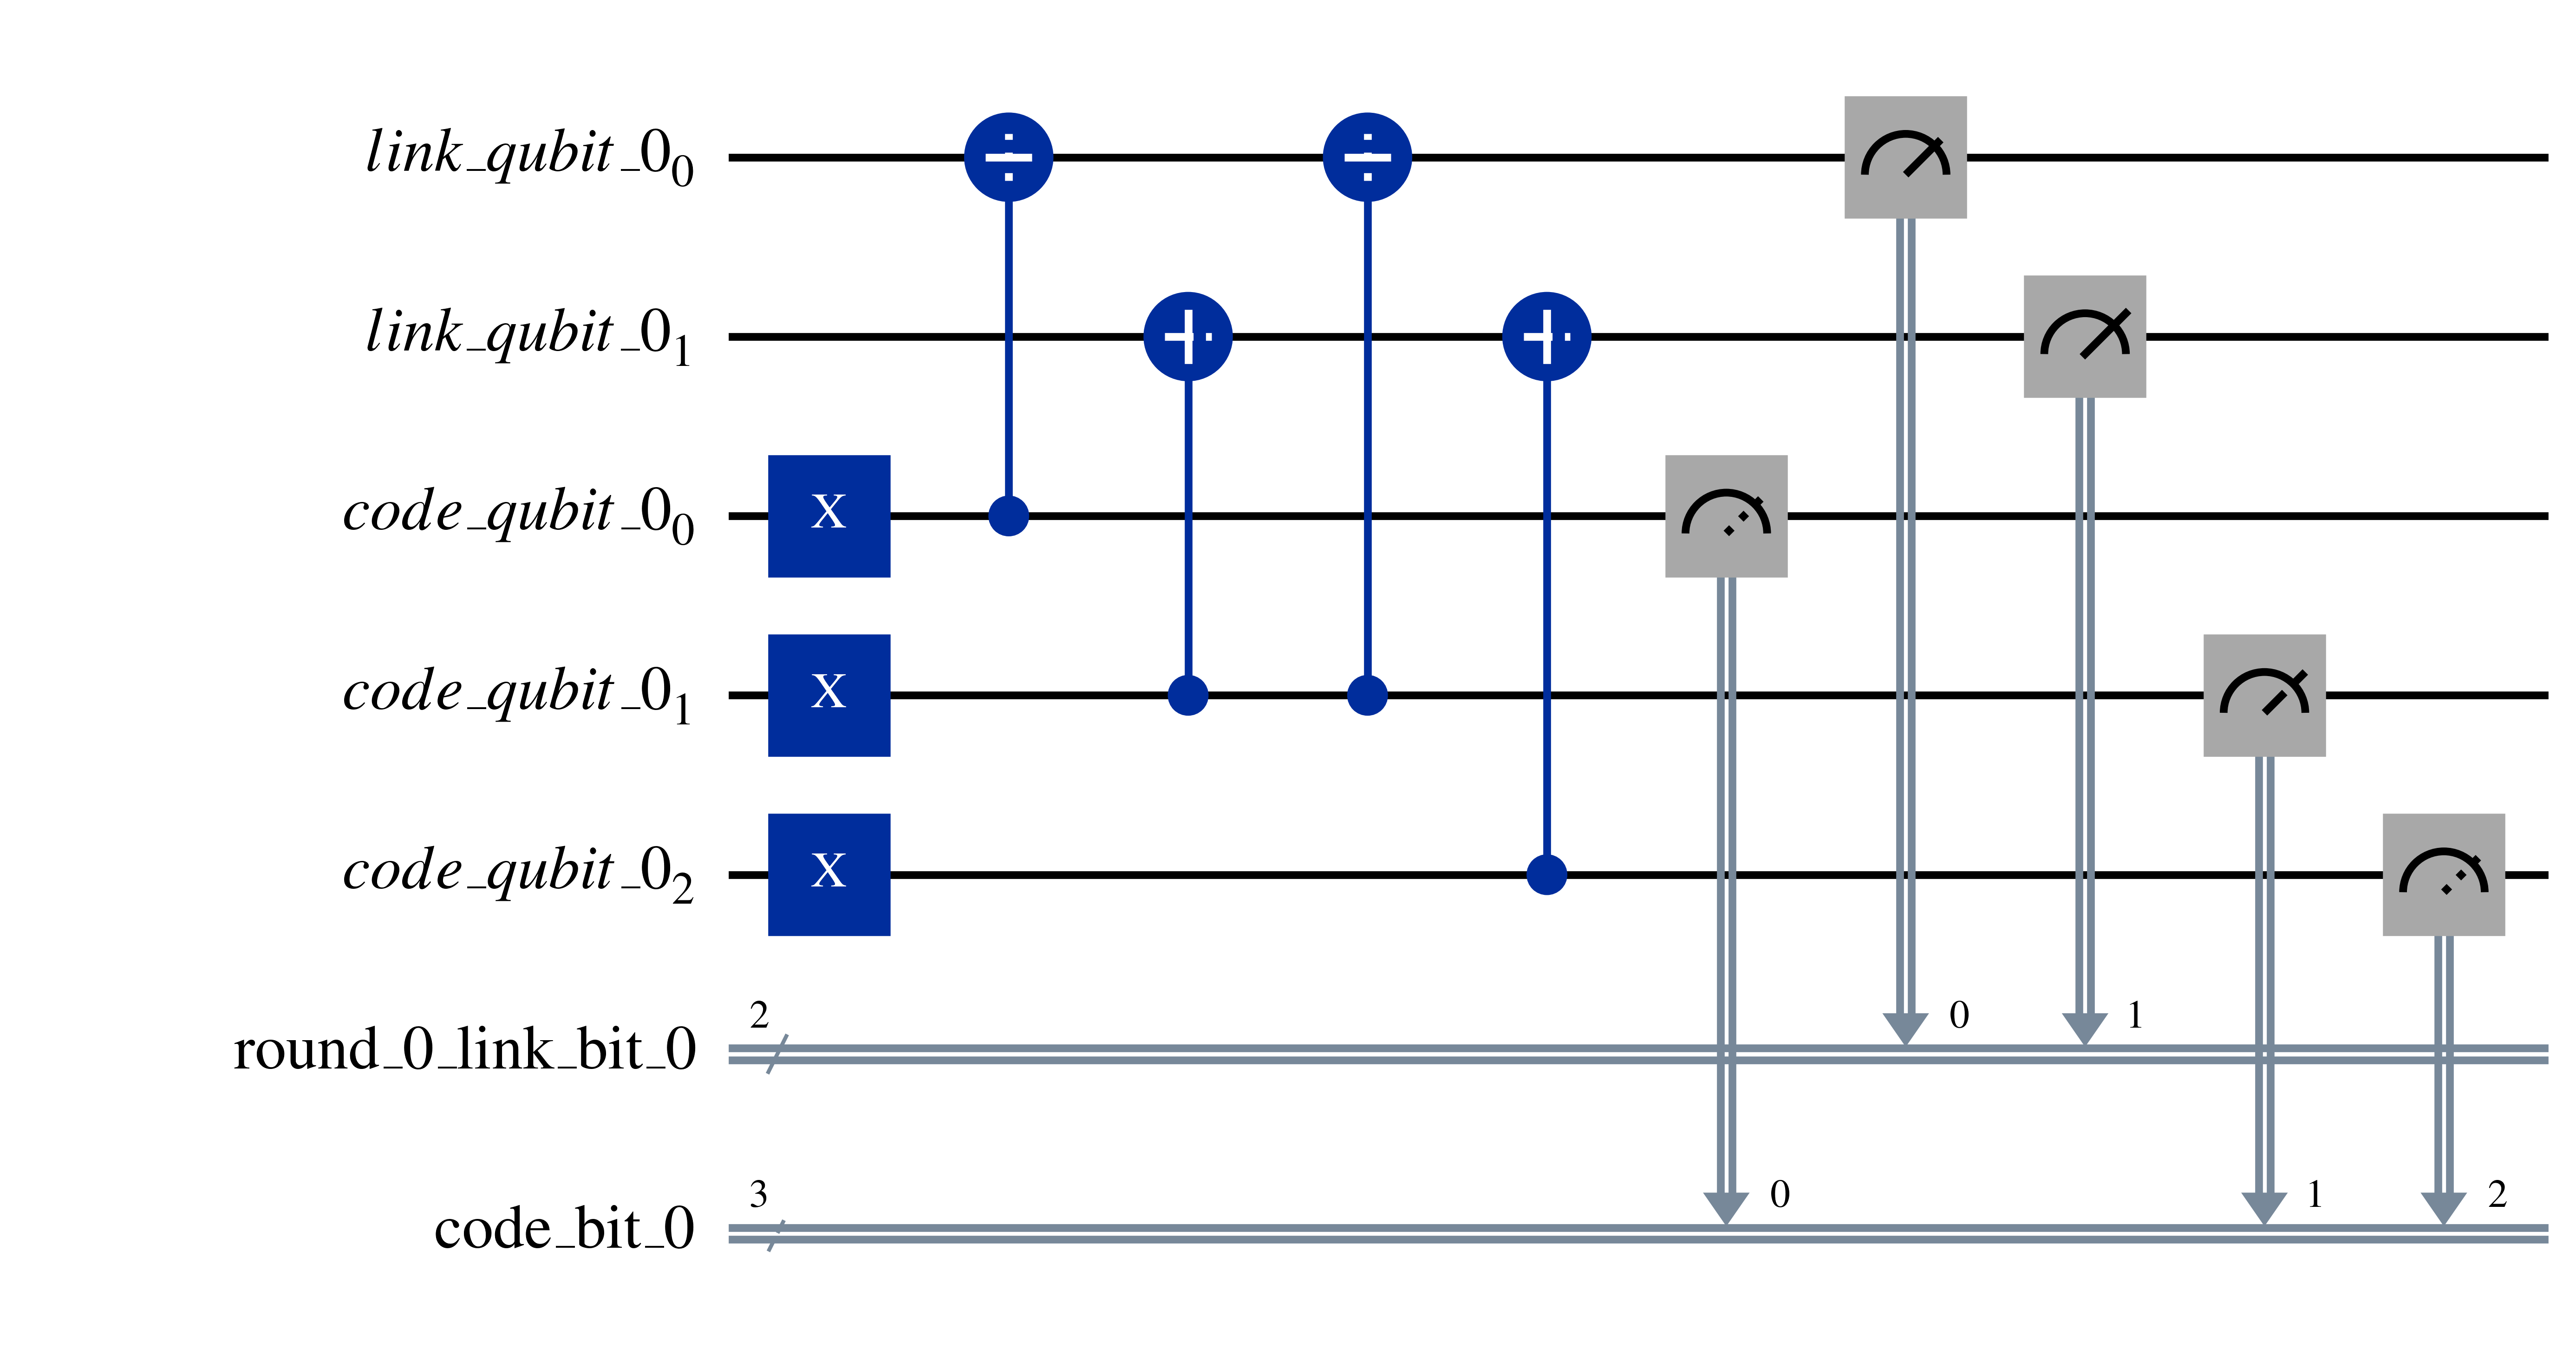

In [16]:
code.circuit['1'].draw('mpl')

In these circuits, we have two types of physical qubits. There are the 'code qubits', which are the three physical qubits across which the logical state is encoded. There are also the 'link qubits', which serve as the ancilla qubits for the syndrome measurements.

Our single round of syndrome measurements in these circuits consist of just two syndrome measurements. One compares code qubits 0 and 1, and the other compares code qubits 1 and 2. One might expect that a further measurement, comparing code qubits 0 and 2, should be required to create a full set. However, these two are sufficient. This is because of the information on whether 0 and 2 have the same z basis state can be inferred from the same information about 0 and 1 with that for 1 and 2. Indeed, for $n$ qubits, we can get the required information from just $n-1$ syndrome measurements of neighbouring pairs of qubits.

Running these circuits on a simulator without any noise leads to very simple results.

In [17]:
def get_raw_results(code, simulators):
    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        for sim_name, simulator in simulators.items():
            job = simulator.run(circuits[log])
            if sim_name not in raw_results:
                raw_results[sim_name] = {}
            raw_results[sim_name][str(log)] = job.result().get_counts(str(log))
    return raw_results

simulators = {'ideal': sim_ideal, 'bit flip noise': sim_noise, 'thermal noise': sim_thermal}
raw_results = get_raw_results(code, simulators)

for sim_name, results in raw_results.items():
    print(f'Simulator: {sim_name}')
    for log in results:
        print(f'  Logical {log}: {results[log]}')

Simulator: ideal
  Logical 0: {'000 00': 1024}
  Logical 1: {'111 00': 1024}
Simulator: bit flip noise
  Logical 0: {'111 00': 2, '011 01': 3, '011 11': 3, '100 11': 4, '010 10': 23, '111 01': 2, '001 10': 12, '101 10': 3, '001 01': 13, '010 11': 16, '100 10': 13, '110 00': 9, '010 00': 87, '100 01': 12, '001 11': 4, '101 00': 9, '110 11': 1, '010 01': 36, '011 00': 9, '001 00': 76, '000 11': 21, '110 10': 3, '000 01': 82, '000 00': 414, '000 10': 88, '110 01': 7, '100 00': 72}
  Logical 1: {'010 01': 1, '100 10': 3, '110 11': 3, '101 01': 38, '001 01': 4, '000 10': 1, '010 11': 2, '110 10': 18, '100 01': 6, '010 00': 8, '001 11': 2, '101 00': 64, '011 11': 1, '101 11': 12, '011 01': 11, '111 11': 28, '101 10': 16, '100 11': 2, '011 10': 11, '001 00': 9, '011 00': 63, '110 00': 85, '110 01': 14, '100 00': 13, '001 10': 4, '111 01': 98, '111 10': 86, '010 10': 2, '111 00': 419}
Simulator: thermal noise
  Logical 0: {'000 00': 1024}
  Logical 1: {'100 00': 1, '111 01': 6, '101 01': 9, '1

In [18]:
plot_histogram([raw_results['ideal']['0'], raw_results['ideal']['1']], legend=['0', '1'], color=['crimson','midnightblue'],
                title="Measurement Outcome for Ideal Model", figsize= (20, 10))

In [19]:
plot_histogram([raw_results['bit flip noise']['0'], raw_results['bit flip noise']['1']], legend=['0', '1'], color=['crimson','midnightblue'],
                title="Measurement Outcome for Bit Flip Noise Model", figsize= (20, 10))

In [20]:
plot_histogram([raw_results['thermal noise']['0'], raw_results['thermal noise']['1']], legend=['0', '1'], color=['crimson','midnightblue'],
                title="Measurement Outcome for Thermal Noise Model", figsize= (20, 10))

In [21]:
n = 3
T = 2

code = RepetitionCode(n, T)

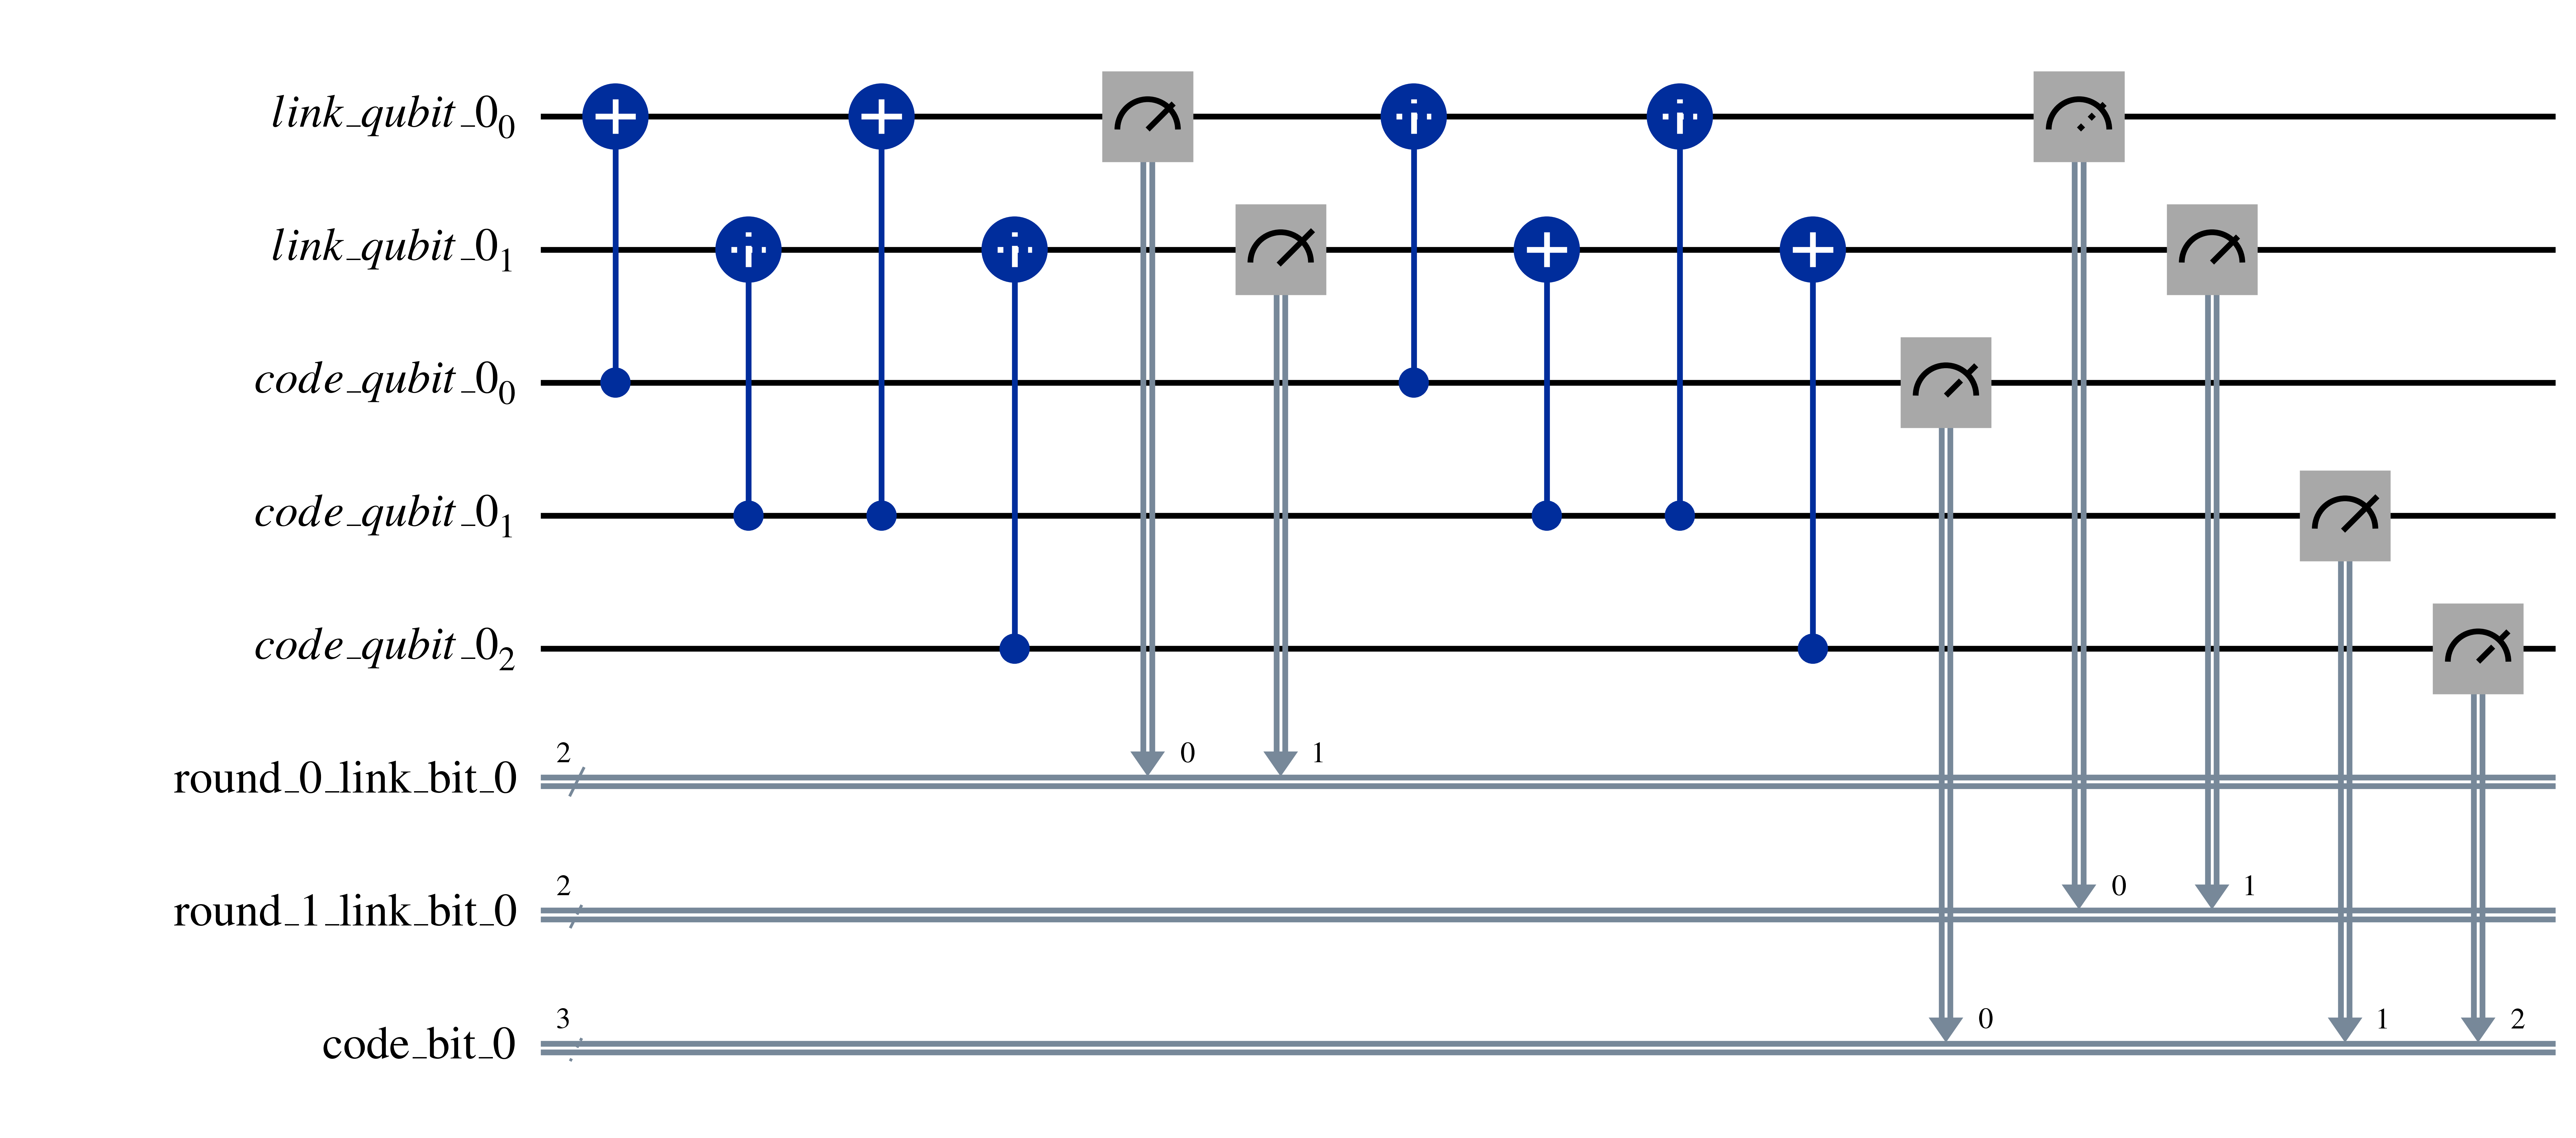

In [22]:
code.circuit['0'].draw('mpl')

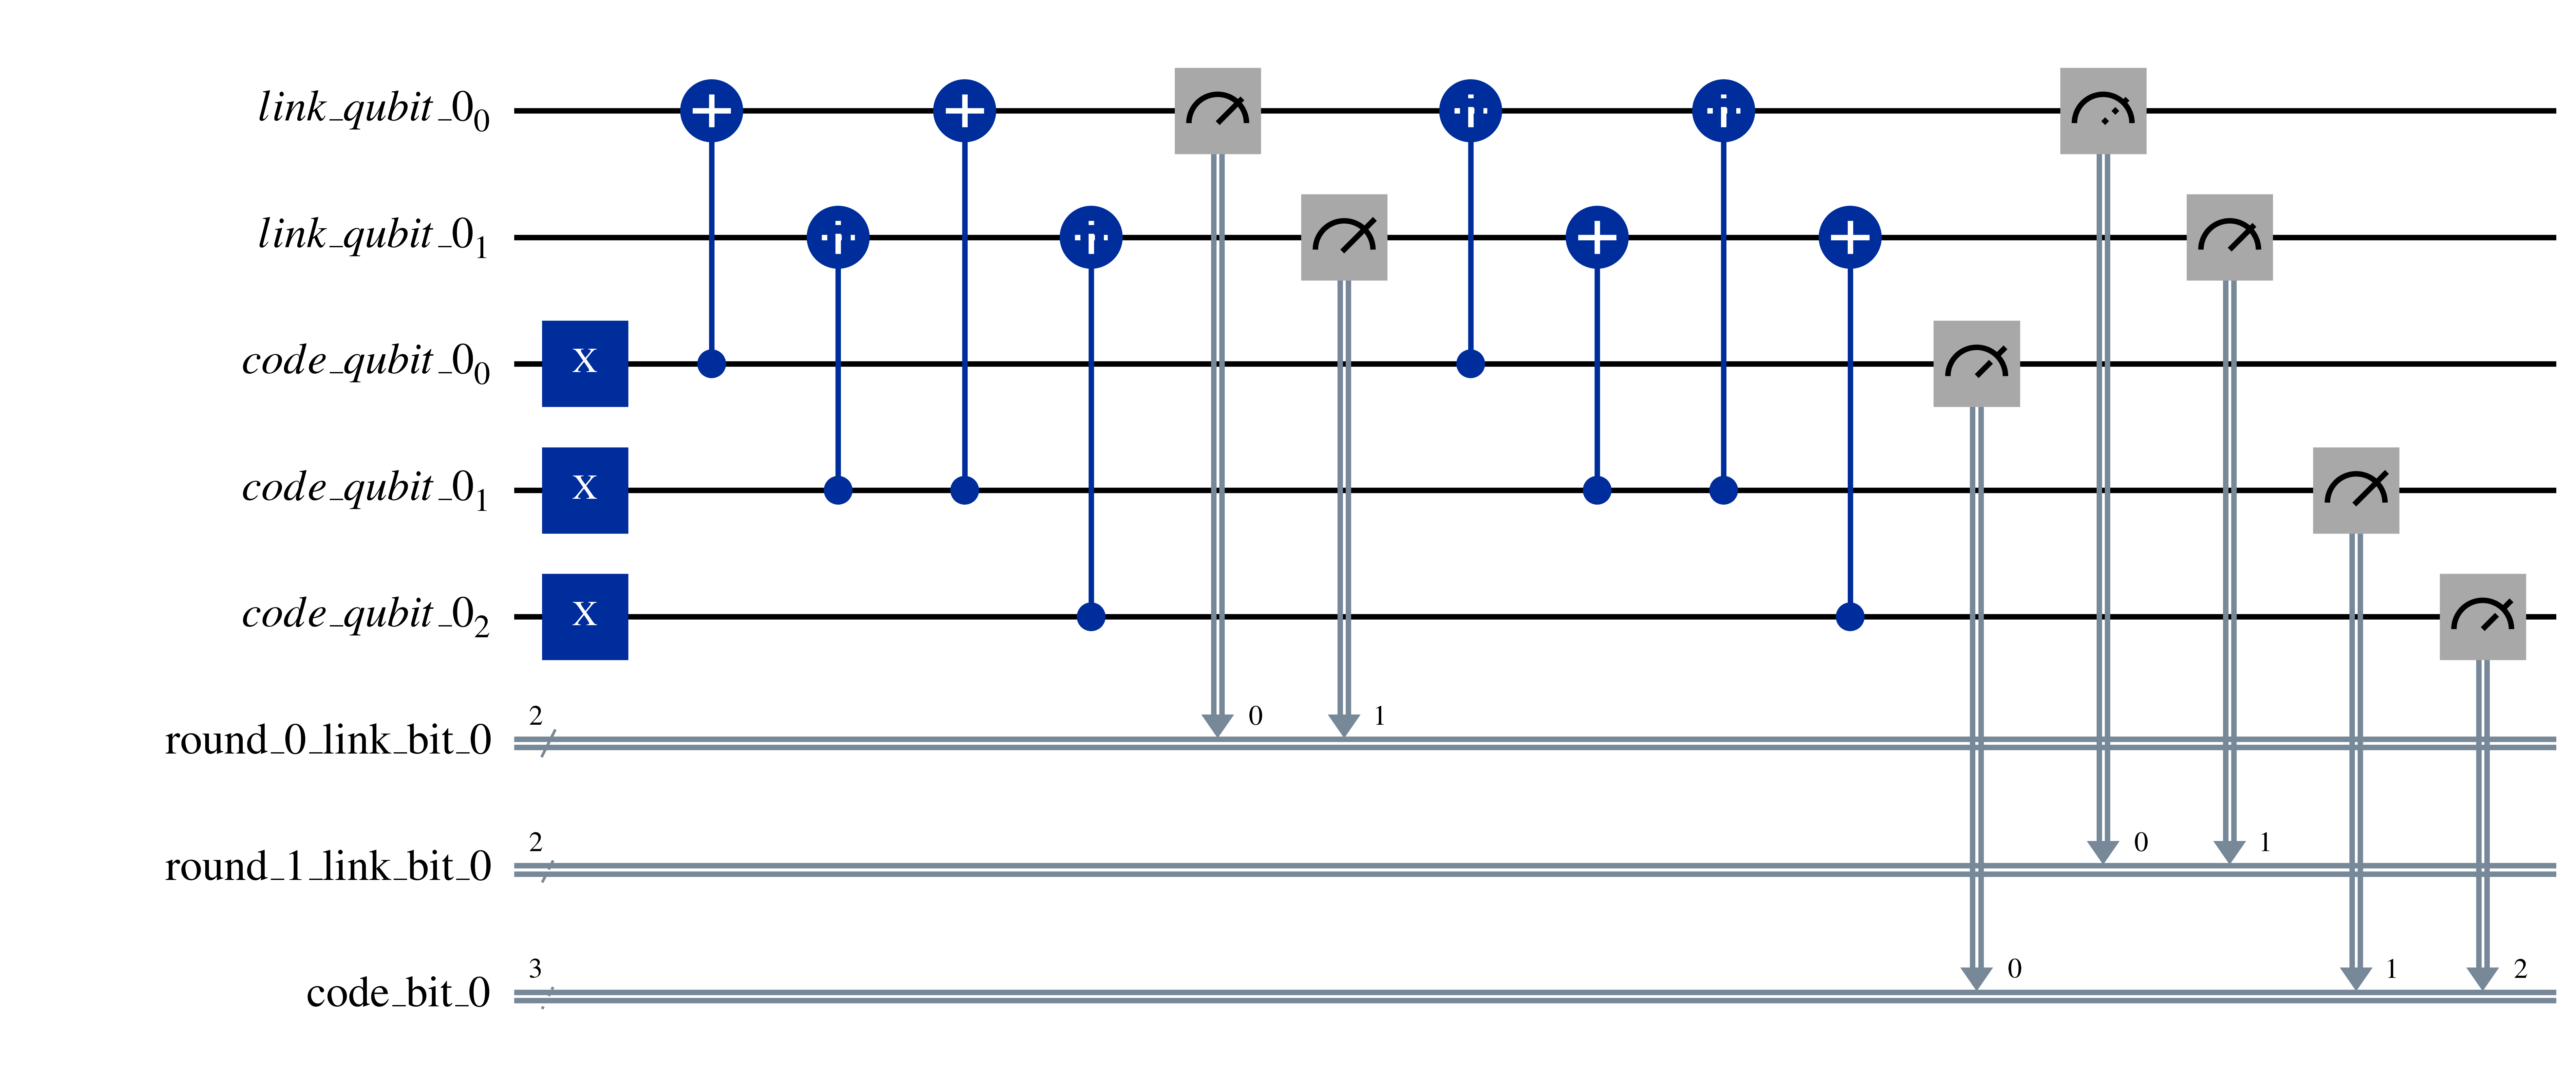

In [23]:
code.circuit['1'].draw('mpl')

In [24]:
def get_raw_results(code, simulators):
    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        for sim_name, simulator in simulators.items():
            job = simulator.run(circuits[log])
            if sim_name not in raw_results:
                raw_results[sim_name] = {}
            raw_results[sim_name][str(log)] = job.result().get_counts(str(log))
    return raw_results

simulators = {'ideal': sim_ideal, 'bit flip noise': sim_noise, 'thermal noise': sim_thermal}
raw_results = get_raw_results(code, simulators)

for sim_name, results in raw_results.items():
    print(f'Simulator: {sim_name}')
    for log in results:
        print(f'  Logical {log}: {results[log]}')

Simulator: ideal
  Logical 0: {'000 00 00': 1024}
  Logical 1: {'111 00 00': 1024}
Simulator: bit flip noise
  Logical 0: {'100 01 11': 3, '011 01 11': 1, '111 11 01': 1, '001 10 01': 1, '111 10 10': 1, '001 10 10': 10, '110 10 11': 1, '110 01 01': 2, '011 10 11': 1, '001 00 01': 3, '001 01 11': 1, '101 11 11': 1, '011 01 10': 3, '010 00 11': 2, '101 01 01': 1, '101 10 00': 2, '011 00 10': 3, '000 01 11': 2, '000 00 11': 1, '100 11 10': 2, '100 11 00': 7, '001 10 00': 11, '101 01 10': 1, '110 11 10': 1, '001 01 01': 8, '000 01 10': 2, '100 00 10': 5, '010 11 11': 3, '001 11 00': 4, '110 01 11': 1, '010 01 01': 9, '110 10 00': 7, '000 00 01': 12, '001 11 10': 9, '010 10 10': 10, '000 11 10': 14, '010 00 01': 11, '110 11 00': 5, '011 10 01': 5, '010 11 01': 7, '101 11 00': 3, '100 10 00': 17, '011 10 10': 2, '011 11 00': 5, '000 10 00': 55, '101 00 00': 6, '011 01 00': 4, '100 11 11': 1, '100 01 00': 8, '001 11 01': 2, '000 00 00': 217, '011 00 01': 4, '101 10 11': 1, '000 01 01': 55, '0

In [25]:
n = 5
T = 4

code = RepetitionCode(n, T)

In [26]:
def get_raw_results(code, simulators):
    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        for sim_name, simulator in simulators.items():
            job = simulator.run(circuits[log])
            if sim_name not in raw_results:
                raw_results[sim_name] = {}
            raw_results[sim_name][str(log)] = job.result().get_counts(str(log))
    return raw_results

simulators = {'ideal': sim_ideal, 'bit flip noise': sim_noise, 'thermal noise': sim_thermal}
raw_results = get_raw_results(code, simulators)

for sim_name, results in raw_results.items():
    print(f'Simulator: {sim_name}')
    for log in results:
        print(f'  Logical {log}: {results[log]}')

Simulator: ideal
  Logical 0: {'00000 0000 0000 0000 0000': 1024}
  Logical 1: {'11111 0000 0000 0000 0000': 1024}
Simulator: bit flip noise
  Logical 0: {'00101 1100 0100 1111 0110': 1, '11001 0100 1010 1000 0000': 1, '00000 1111 1010 1110 1010': 1, '00011 1101 0101 0001 0000': 1, '01101 1010 0000 1100 0000': 1, '00000 0100 0111 0110 0001': 1, '10010 0100 0111 0111 0011': 1, '11000 0110 0110 0010 0010': 1, '00000 1000 1100 1110 1100': 1, '00000 0010 0010 0011 0010': 1, '00000 1100 1100 0100 0100': 1, '01000 0101 0001 1101 0001': 1, '01000 0101 0001 1000 1000': 1, '00100 0001 0001 0001 0001': 1, '01000 1111 1010 1101 1000': 1, '00000 1000 0100 1000 0100': 1, '01000 0000 0000 0100 0100': 1, '10001 0110 0110 1110 0101': 1, '00000 0000 0001 1001 0001': 1, '00000 0111 0100 0111 0110': 1, '01000 0101 0001 0001 0000': 1, '01010 0001 1111 0001 1100': 1, '00000 1110 0010 0011 0010': 1, '00100 0000 0010 0010 0010': 1, '00000 1110 0101 0110 0100': 1, '10100 1001 1001 0000 0000': 1, '00010 0011 0

In [27]:
n_min = 3
line = [13,14,0,1,2,12,11,3,4,10,9,5,6,8,7]
n_max = int((len(line)+1)/2)

code = {}

for n in range(n_min,n_max+1):
    code[n] = RepetitionCode(n,1)

In [28]:
def get_initial_layout(code,line):
    initial_layout = {}
    for j in range(n):
        initial_layout[code.code_qubit[j]] = line[2*j]
    for j in range(n-1):
        initial_layout[code.link_qubit[j]] = line[2*j+1]
    return initial_layout

In [29]:
circuits = []
for n in range(n_min,n_max+1):
    initial_layout = get_initial_layout(code[n],line)
    for log in ['0','1']:
        circuits.append( transpile(code[n].circuit[log], backend=sim_noise, initial_layout=initial_layout) )
        num_cx = dict(circuits[-1].count_ops())['cx']
        assert num_cx==2*(n-1), str(num_cx) + ' instead of ' + str(2*(n-1)) + ' cx gates for n = ' + str(n)

In [30]:
job = sim_noise.run(circuits,shots=8192)

raw_results = {}
j = 0
for d in range(n_min,n_max+1):
    raw_results[d] = {}
    for log in ['0','1']:
        raw_results[d][log] = job.result().get_counts(j)
        j += 1

In [31]:
results = {}
for n in range(n_min,n_max+1):
    results[n] = code[n].process_results( raw_results[n] )
    
dec = {}
for n in range(n_min,n_max+1):
    dec[n] = GraphDecoder(code[n])

In [32]:
logical_prob_match = {}
for n in range(n_min,n_max+1):
    logical_prob_match[n] = dec[n].get_logical_prob(results[n])

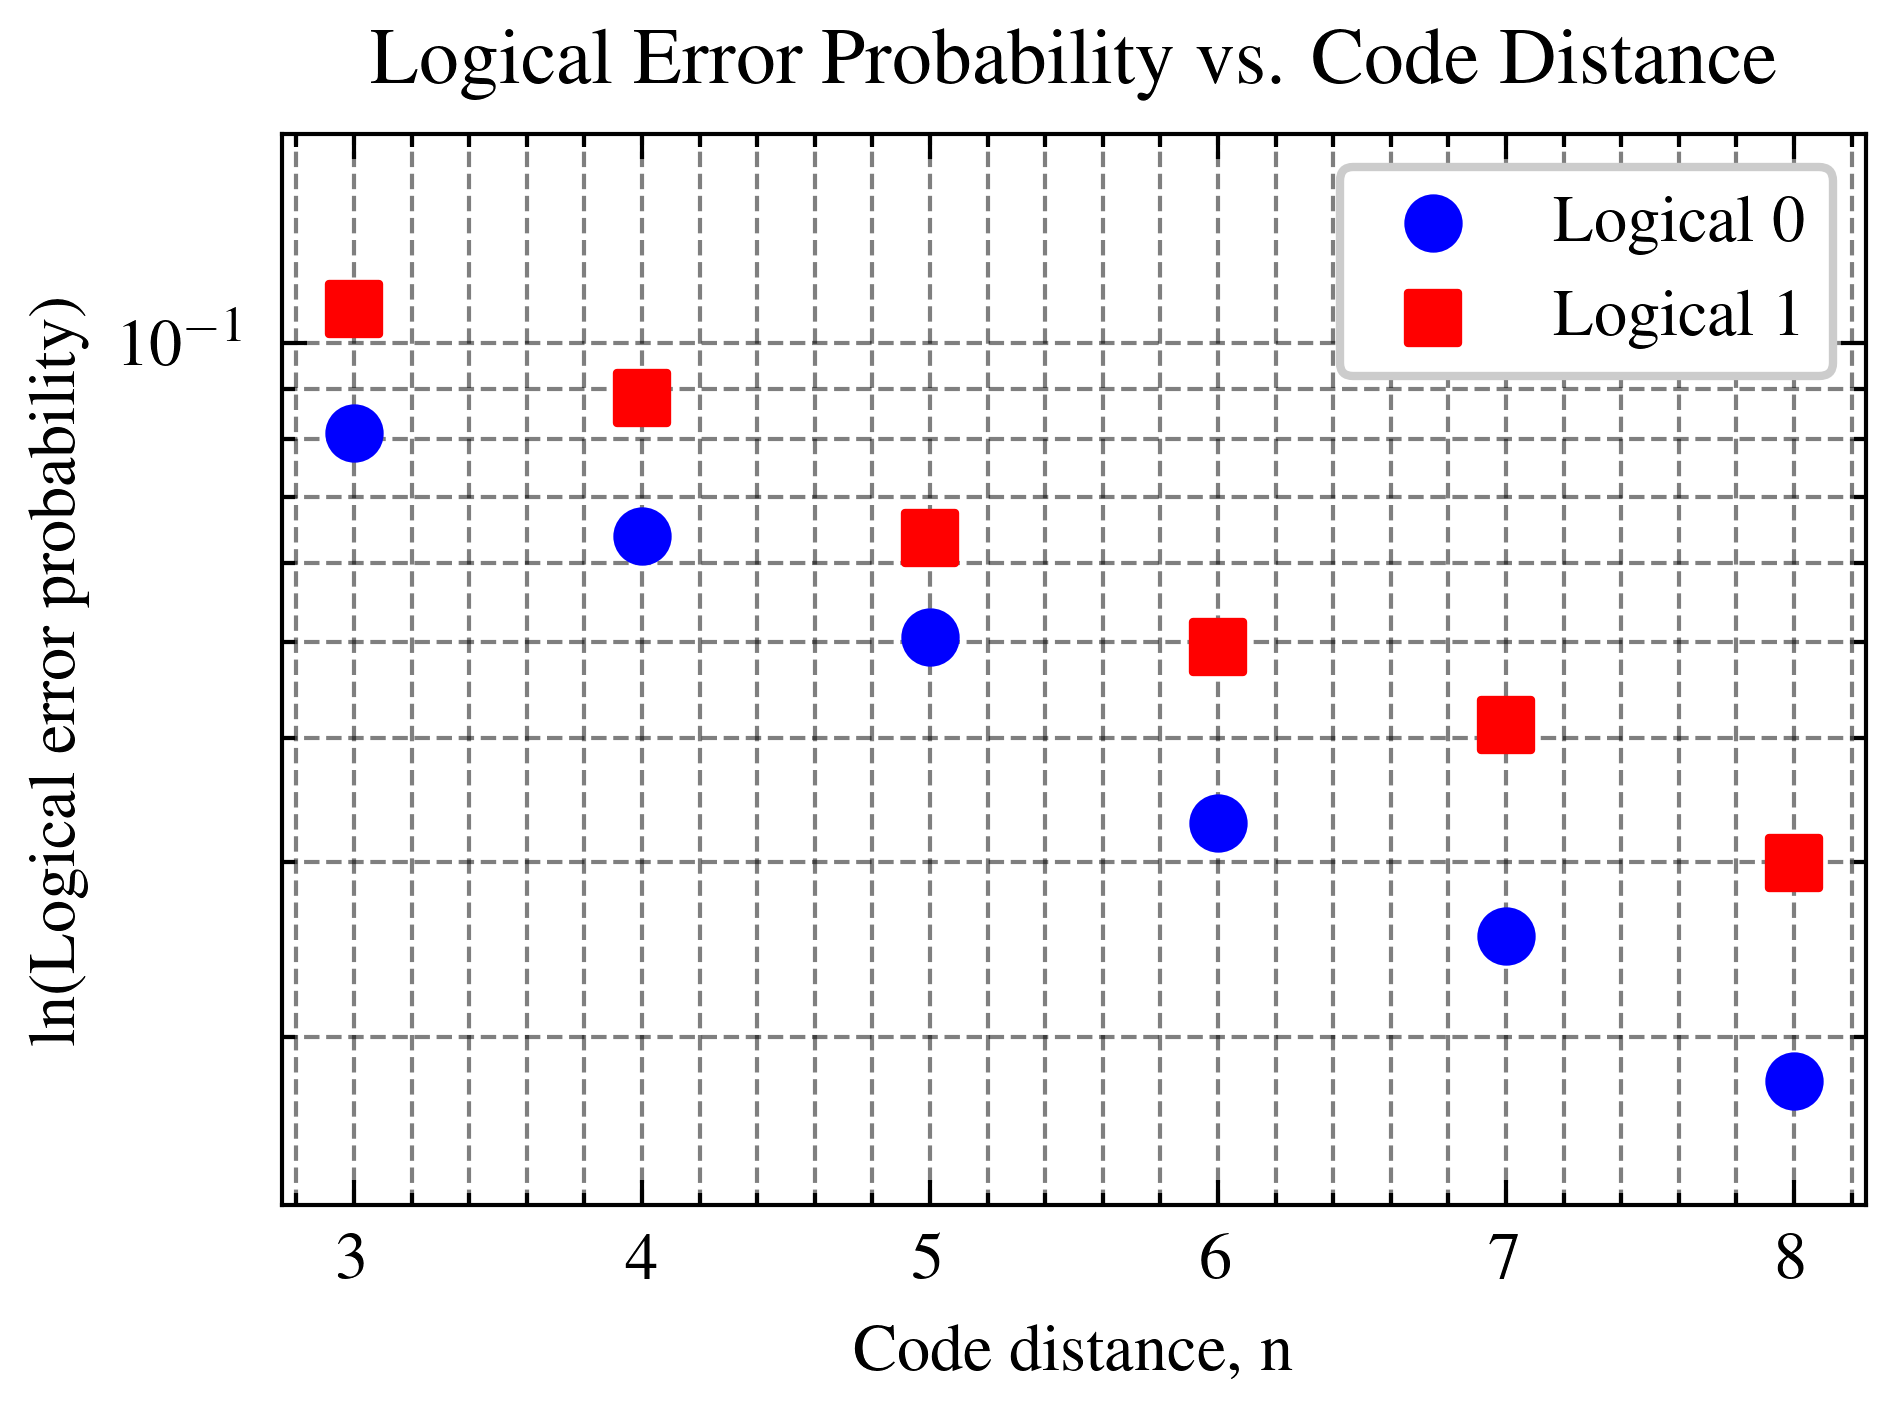

In [33]:
x_axis = range(n_min, n_max + 1)
P = {log: [logical_prob_match[n][log] for n in x_axis] for log in ['0', '1']}

fig, ax = plt.subplots()
plt.xlabel('Code distance, n')
plt.ylabel('ln(Logical error probability)')
ax.scatter(x_axis, P['0'], label="Logical 0", color='blue', marker='o')
ax.scatter(x_axis, P['1'], label="Logical 1", color='red', marker='s')
ax.set_yscale('log')
ax.set_ylim(ymax=1.5 * max(P['0'] + P['1']), ymin=0.75 * min(P['0'] + P['1']))
ax.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.title('Logical Error Probability vs. Code Distance')
plt.tight_layout()
plt.savefig('plots/log_err_code_distance.pdf')
plt.show()